# Évolution temporelle du signal généré par l'oscillateur à pont de Wien


Soit l'oscillateur à pont de Wien suivant :


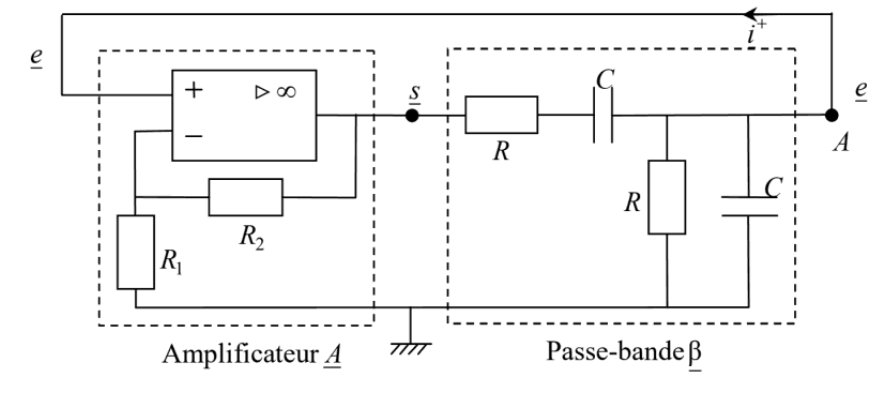

On note $\underline{A}$ la fonction de transfert du montage amplificateur, qui est constante et réelle dans l'approche de l'ALI parfait en régime linéaire.
On note $\beta$ la fonction de transfert du filtre à pont de Wien :
\begin{equation}
\beta(\omega) = \beta_0  \frac{ j  \frac{\omega}{\omega_0 * Q}}{1 + j \frac{\omega}{\omega_0 * Q} - \frac{\omega^2}{\omega_0^2}}
\end{equation}
avec Q=$\frac{1}{3}$, $\omega_0= \frac{1}{R*C}$ et $\beta_0=\frac{1}{3}$

En repassant dans le domaine temporelle les deux équations liant s(t) et e(t), on obtient l'équation différentielle vérifiée par s ou e (n'oublions pas que les tensions e et s sont proportionnelles grâce à l'amplificateur) :
\begin{equation}
\frac{d^2s}{dt^2} + \frac{\omega_0}{Q}(1 - A*\beta_0)\frac{ds}{dt} + \omega_0^2 s = 0
\end{equation}

## I. Résolution avec le solveur de python solve_ivp
> ### I.1 Étude numérique

In [3]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

On définit tout d'abord tous les paramètres utiles :

In [4]:
#R = 1e3     # Ohm, resistance du filtre passe-bande
#C = 100e-9  # Farad, capacité du filtre passe bande
omega_0 = 1 # pulsation propre que l'on choisit égal à 1, de manière adimensionnée.

Q = 1/3  # facteur de qualité
beta_0 = 1/3  # gain statique du filtre de Wien
A = 3.1 # gain de l'amplificateur

On définit les conditions initiales pour les tensions e et s : on choisit ici de commencer avec une petite perturbation sur la sortie de l'ALI.


In [5]:
# Définition des conditions initiales
C_0 = 0.01  # tension de sortie de l'ALI 
C_1 = 0  # dérivée de la tension de sortie de l'ALI

On rentre le système différentiel à résoudre. Comme il s'agit d'une équation différentielle d'ordre 2 que l'on souhaite résoudre sur python, il faut d'abord la transformer en un système d'équation différentielle d'ordre 1. On introduit alors la notation suivante $x1=s(t)$ et $x2=\frac{ds}{dt}$ :

In [6]:
# Définition du système d'équation différentielle
def systeme(t, X):
    x_1 = X[0]
    x_2 = X[1]

    dx1_dt = x_2
    dx2_dt = -omega_0/Q*(1-A*beta_0)*x_2 - omega_0**2 *x_1

    return [dx1_dt, dx2_dt]

t représente la varialbe temps et X la variable portant l'inconnue s(t) et sa dérivée première.

On s'occupe du temps, en définissant les instants initial et final et en créant la liste des différents temps : ici on prend 100 points pour tracer l'axe temporel.

In [7]:
t0 = 0 
tf = 120 
N0 = 100 # nombre d'échantillons du signal temporel

t = np.linspace(t0,tf,N0)

On utilise alors solve_ivp du package scipy.integrate. 

In [8]:
solution = solve_ivp(systeme, [t0, tf], [C_0, C_1], method='RK45',max_step=0.1)

On a rentré comme argument à la fonction solve_ivp tout d'abord le système différentiel, puis les instants de départ et de fin, puis les conditions initiales, puis la méthode d'intégration numérique utilisé dans l'algorithme solve_ivp - ici Runge Kutta d'ordre 5 - et enfin le pas maximum d'intégration. 
solve_ivp renvoie un tableau avec différentes informations dont notamment le temps, et la solution, appelables via solution.t et solution.y.

Il ne reste plus qu'à tracer la solution avec plot.scatter comme un nuage de points : 

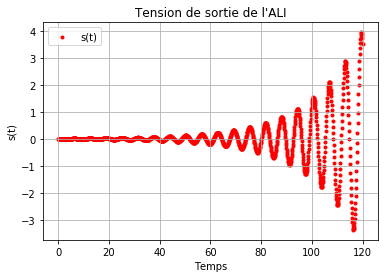

In [9]:
plt.scatter(solution.t, solution.y[0], label="s(t)", color='red',marker='.')
plt.ylabel('s(t)')
plt.xlabel("Temps")
plt.title("Tension de sortie de l'ALI")
plt.grid(which="both")
plt.legend()
plt.show()


Il suffit alors de jouer avec le coefficient A pour modifier l'évolution temporelle de la tension de sortie.

Néanmoins en fonctionnant ainsi, on ne tient pas compte de l'éventuelle saturation de l'ALI. On propose alors une deuxième manière de résoudre le système d'équation différentielle conditionnelle, cette fois-ci en utilisant la méthode d'Euler directement.

> ### I.2 Analyse fréquentielle du signal

Il s'agit ici de réaliser la transformée de Fourier d'un signal discret. Mathématiquement, pour un signal numérique x$[k]$ contenant N valeurs, cela correspond à la formule suivante :
\begin{equation}
X[k] = \sum_{n=0}^{N-1} x[n]*exp(-j 2 \pi \cdot \frac{k\cdot n}{N})
\end{equation}

On obtient alors la transformée discrète de Fourier notée X, qui est une fonction à valeurs complexes.

Numériquement, Il existe plusieurs implantations dans Python de la FFT, et nous allons utiliser celle du package scipy.fft. 


**scipy.fft.fft(x, n=None, axis=- 1, norm=None, overwrite_x=False, workers=None, *, plan=None)** 


> x est un array qui peut être complexe,

> n est un entier qui spécifie la taille de l'axe de la transformée, par défaut c'est la taille de x,

> Pour les autres options, il faut se référer à l'aide de scipy.


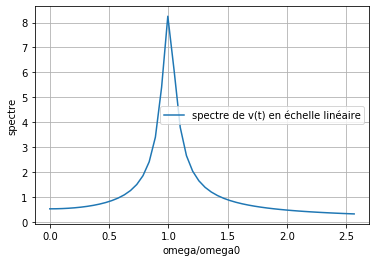

In [11]:
from scipy.fft import fft, rfft, fftfreq # les deux fonctions que l'on peut utiliser, rfft fonctionne si x est réel
                                        # fftfreq retourne la liste des fréquences 

spectre = fft(solution.y[0]) # on calcule ici la transformée discrète de Fourier de la solution s(t)

T=tf/N0

xf = fftfreq(N0, T)[:N0//2]  # ici on se donne la liste des fréquences en ne prenant que la deuxième moitié
                             # positive des fréquences

# Graphique

plt.figure()
plt.plot(xf*2*np.pi, 2.0/N0 * np.abs(spectre[0:N0//2]),label="spectre de v(t) en échelle linéaire") 
# l'axe des fréquences est ici multiplié par 2pi pour avoir l'axe des pulsations et pouvoir comparer facilement à omega0
# le facteur 2.0/N0 permet de normaliser le signal

plt.xlabel('omega/omega0')
plt.ylabel('spectre')
plt.grid()
plt.legend(loc='best')

plt.show()

## II. Résolution du système différentiel en tenant compte de la saturation : méthode d'Euler
### II.1 Étude numérique

On reprend le même point de départ avec la déclaration des différents paramètres utiles :

In [13]:
import numpy as np
import matplotlib.pyplot as plt 

R = 1e3     # Ohm, resistance du filtre passe-bande
C = 100e-9  # Farad, capacité du filtre passe bande
A = 3.15     # 1, gain de l'amplificateur (soit 1+R2/R1), la valeur seuil est de 3
w0 = 1/(R*C)

tfin = 20.e-3  # secondes, t final de la simulation
dt   = 0.01e-3 # secondes, pas de temps
vsat = 15      # volts, tension de saturation de l’ALI


Mais ici on va construire avec une boucle while pas à pas l'ensemble des grandeurs temporelles et de tension. Pour ce faire, on utilise la fonction append pour rajouter à la liste des grandeurs utiles chaque élément calculé via la méthode d'Euler.

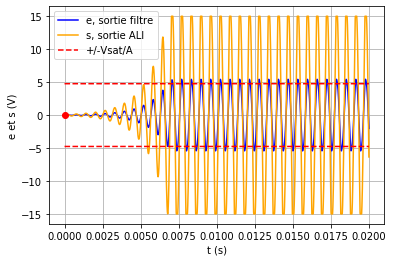

In [14]:

# Initialisation des variables
t = [0.0]      # temps

e = [0.01]     # sortie du flitre (et donc aussi entrée v+ de l'ALI)
s = [0.0]      # sortie de l'ALI

dedt = [0.01]  # dérivée de e : de/dt, on l'initialise avec une petite perturbation
dsdt = [0.0]   # dérivée de s : ds/dt

# Boucle d'intégration 
while t[-1] < tfin:
    d2edt2 = w0*dsdt[-1] - 3*w0*dedt[-1] - w0**2*e[-1] # dérivée seconde de e, obtenue via l'équation sur e
    dedt.append( dedt[-1] + d2edt2*dt )                # nouvelle valeur de de/dt
    e.append(e[-1] + dedt[-1]*dt)                      # nouvelle valeur de e
    
    if e[-1] < -vsat/A:     # pour actualiser s, il faut voir 
        s.append(-vsat)     # si il va y avoir saturation ou non 
    elif e[-1] > vsat/A:    # de la sortie de l'ALI
        s.append(vsat)
    else:
        s.append(A*e[-1])
        
    dsdt.append((s[-1]-s[-2])/dt)  # On aura besoin de ds/dt pour la suite
    t.append(t[-1]+dt)

# Graphiques 
plt.figure()
plt.plot(t,e,label="e, sortie filtre", color='blue')
plt.plot(t,s,'-',label="s, sortie ALI", color='orange')
plt.plot(0,0.01,'ro')
plt.plot(t,vsat/A*np.ones(len(t)),'r--',label="+/-Vsat/A")
plt.plot(t,-vsat/A*np.ones(len(t)),'r--')
plt.xlabel('t (s)')
plt.ylabel('e et s (V)')
plt.grid()
plt.legend(loc='best')
plt.show()


### II.2 Étude fréquentielle


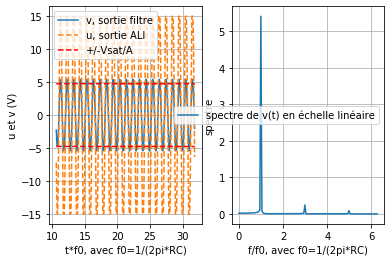

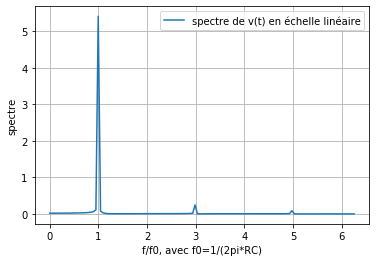

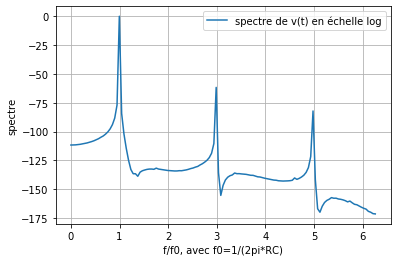

In [17]:
from scipy.fft import fft, rfft

N0 = len(t)
t1 = np.array(t[N0//3:])  # on exclut le 1er tiers du signal pour enlever la phase transitoire de croissance des oscillations, et ne faire le spectre que du régime permanent.
v1 = np.array(e[N0//3:])  # de croissance des oscillations, et ne faire le spectre que du régime permanant.
u1 = np.array(s[N0//3:])

dt = dt     # pas de temps
N = len(t1) # nombre de points
T = N*dt    # durée totale de l'enregistrement
x = t1 
y = v1

yf = rfft(y)
Naff = N//10 # nb de points à afficher pour le spectre
xf = np.linspace(0., Naff*1./T, Naff) * 2.*np.pi/w0

# Graphiques

plt.figure()
plt.subplot(121) # On affiche la portion du signal sur laquelle est calculé le spectre
T0 = 2.*np.pi/w0
plt.plot(t1/T0,v1,label="v, sortie filtre")
plt.plot(t1/T0,u1,'--',label="u, sortie ALI")
plt.plot(t1/T0,vsat/A*np.ones(len(t1)),'r--',label="+/-Vsat/A")
plt.plot(t1/T0,-vsat/A*np.ones(len(t1)),'r--')
plt.xlabel('t*f0, avec f0=1/(2pi*RC)')
plt.ylabel('u et v (V)')
plt.grid()
plt.legend(loc='best')

plt.subplot(122)
plt.plot(xf, 2.0/N * np.abs(yf[0:Naff]),label="spectre de v(t) en échelle linéaire")
plt.xlabel('f/f0, avec f0=1/(2pi*RC)')
plt.ylabel('spectre')
plt.grid()
plt.legend(loc='best')

plt.show()

Maxi=max(np.abs(yf))
#print(Maxi)

plt.figure
plt.plot(xf, 2.0/N * np.abs(yf[0:Naff]),label="spectre de v(t) en échelle linéaire")
plt.xlabel('f/f0, avec f0=1/(2pi*RC)')
plt.ylabel('spectre')
plt.grid()
plt.legend(loc='best')

plt.show()

plt.figure()
plt.plot(xf, 20 * np.log(np.abs(yf[0:Naff])/Maxi),label="spectre de v(t) en échelle log")
plt.xlabel('f/f0, avec f0=1/(2pi*RC)')
plt.ylabel('spectre')
plt.grid()
plt.legend(loc='best')

plt.show()